# Featurize TNG

In this notebook, we analyze the TNG cosmological simulation. Our goal is to take the particles in dark matter only simulations, and predict the properties of galaxies and halos in the corresponding hydrodynamic simulation.

To do this, we compute scalar features of the particle distributions, and perform a linear regression to predict the desired properties.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import sys
from sklearn.model_selection import train_test_split
import h5py
import matplotlib.gridspec as gridspec

# shouldn't need this if have illustris_python properly in python path! todo: check if fixed upon reload
sys.path.insert(1, '/home/ksf293/external')
import illustris_python as il

sys.path.insert(1, '../code')
import utils
import scalars

%load_ext autoreload
%autoreload 2

## Load in data and set up inputs & outputs

Set up paths and variables:

In [2]:
save_tag = ''
save_plots = False

In [3]:
tng_path_hydro = '/scratch/ksf293/gnn-cosmology/data/TNG50-4'
tng_path_dark = '/scratch/ksf293/gnn-cosmology/data/TNG50-4-Dark'
base_path_hydro = '/scratch/ksf293/gnn-cosmology/data/TNG50-4/output'
base_path_dark = '/scratch/ksf293/gnn-cosmology/data/TNG50-4-Dark/output'
snap_num_str = '099'
snap_num = int(snap_num_str)

In [4]:
ipart_dm = il.snapshot.partTypeNum('dm') # 0
ipart_star = il.snapshot.partTypeNum('stars') # 4
mass_multiplier = 1e10

In [5]:
with h5py.File(f'{base_path_hydro}/snapdir_{snap_num_str}/snap_{snap_num_str}.0.hdf5','r') as f:
    header = dict( f['Header'].attrs.items() )

m_dmpart = header['MassTable'][1] # this times 10^10 msun/h
print(f"Mass of dark matter particles: {m_dmpart*1e10:.4e} Msun/h")

Mass of dark matter particles: 1.5737e+08 Msun/h


Load in dark and full sims:

In [6]:
fields = ['SubhaloMass','SubhaloPos','SubhaloMassType', 'SubhaloLenType', 'SubhaloHalfmassRad', 'SubhaloGrNr']

subhalos_hydro = il.groupcat.loadSubhalos(base_path_hydro,snap_num,fields=fields)
halos_hydro = il.groupcat.loadHalos(base_path_hydro,snap_num)

subhalos_dark = il.groupcat.loadSubhalos(base_path_dark,snap_num,fields=fields)
halos_dark = il.groupcat.loadHalos(base_path_dark,snap_num)

Create corresponding array of halo IDS:

In [7]:
# I think the halo IDs are just the place in the original list; make this explicit
idxs_halos_hydro_all = np.array(list(range(halos_hydro['count'])))
idxs_halos_dark_all = np.array(list(range(halos_dark['count'])))

Load twin-matching file:

In [8]:
f = h5py.File(f'{tng_path_hydro}/postprocessing/subhalo_matching_to_dark.hdf5','r')
# two different matching algorithms: 'SubhaloIndexDark_LHaloTree' & 'SubhaloIndexDark_SubLink'. choosing first for now
subhalo_full_to_dark_inds = f[f'Snapshot_{snap_num}']['SubhaloIndexDark_LHaloTree']

Build dicts to match subhalos both ways. If a full subhalo has no dark subhalo twin, exclude it.

In [9]:
subhalo_full_to_dark_dict = {}
subhalo_dark_to_full_dict = {}
for i in range(len(subhalo_full_to_dark_inds)):
    idx_full = i
    idx_dark = subhalo_full_to_dark_inds[idx_full]
    if idx_dark == -1:
        continue
    subhalo_dark_to_full_dict[idx_dark] = idx_full
    subhalo_full_to_dark_dict[idx_full] = idx_dark

Get most massive subhalo in each dark halo; then find that subhalo's twin in the full sim. If it doesn't have a twin (aka not in dict), exclude. Then take the twin subhalo's parent halo; this is the associated hydro halo. Finally, take that hydro halo's most massive subhalo (this is most likely the original twin, but may not be).

Also, make some additional cuts:
- If there are no star particles in the matched subhalo in the full sim, exclude.
- If the dark matter halo has a mass below some minimum mass, exclude.
- If the hydro halo is too many times bigger than the associated dark halo, exclude (it is probably a bad match).

In [10]:
# GroupFirstSub: Index into the Subhalo table of the first/primary/most massive 
# Subfind group within this FoF group. Note: This value is signed (or should be interpreted as signed)! 
# In this case, a value of -1 indicates that this FoF group has no subhalos.
halos_dark['GroupFirstSub'] = halos_dark['GroupFirstSub'].astype('int32')
mask_has_subhalos = np.where(halos_dark['GroupFirstSub'] >= 0) # filter out halos with no subhalos

idxs_halos_dark_withsubhalos = idxs_halos_dark_all[mask_has_subhalos]
idxs_largestsubs_dark_all = halos_dark['GroupFirstSub'][mask_has_subhalos]

halo_dicts = []
for i, idx_halo_dark in enumerate(idxs_halos_dark_withsubhalos):
    
    idx_largestsub_dark = idxs_largestsubs_dark_all[i]
    if idx_largestsub_dark in subhalo_dark_to_full_dict:
        
        halo_dict = {}
        
        # This is the index of the hydro subhalo that is the twin of the largest subhalo in the dark halo
        idx_subtwin_hydro = subhalo_dark_to_full_dict[idx_largestsub_dark]
        # This is that hydro subhalo's parent halo in the hydro sim
        idx_halo_hydro = subhalos_hydro['SubhaloGrNr'][idx_subtwin_hydro]
        # This is the largest hydro subhalo of that hydro halo
        idx_subhalo_hydro = halos_hydro['GroupFirstSub'][idx_halo_hydro]

        # if no stars in this subhalo, exclude
        epsilon = 1e-6 #magic
        if subhalos_hydro['SubhaloMassType'][:,ipart_star][idx_subhalo_hydro] < epsilon: 
            continue

        # if halo is below a minimum mass, exclude
        mass_min = 1.0 #magic #units 1e10
        if halos_dark['GroupMass'][idx_halo_dark] < mass_min: 
            continue
            
        # if halo masses differ, exclude
        diff_fac = 3.0 #magic
        if halos_hydro['GroupMass'][idx_halo_hydro] > diff_fac*halos_dark['GroupMass'][idx_halo_dark]: 
            continue
        
        halo_dict['idx_halo_dark'] = idx_halo_dark
        halo_dict['idx_subhalo_hydro'] = idx_subhalo_hydro
        halo_dict['idx_subhalo_dark'] = idx_largestsub_dark
        halo_dict['idx_halo_hydro'] = idx_halo_hydro
        
        halo_dicts.append(halo_dict)
        
halo_dicts = np.array(halo_dicts)

In [11]:
print('Number dark halos in dark sim:', len(idxs_halos_dark_all))
print('Number dark halos with >=1 subhalo:', len(idxs_halos_dark_withsubhalos))
print('Number dark subhalos with a twin in full sim:', len(subhalo_dark_to_full_dict))
print('Number halos after additional cuts above:', len(halo_dicts))
N_halos = len(halo_dicts)
idx_halos_in_halodict = np.arange(N_halos)

Number dark halos in dark sim: 18824
Number dark halos with >=1 subhalo: 17738
Number dark subhalos with a twin in full sim: 18392
Number halos after additional cuts above: 2342


Add needed info to halo dicts, including the target ouput property:

In [12]:
y_scalar = np.empty(N_halos) # 1 mass dimension

for i_hd, halo_dict in enumerate(halo_dicts):
    
    idx_halo_dark = halo_dict['idx_halo_dark']
    halo_dict['r_crit200_dark_halo'] = halos_dark['Group_R_Crit200'][idx_halo_dark]
    halo_dict['mass_dark_halo_dm'] = halos_dark['GroupMassType'][:,ipart_dm][idx_halo_dark]

    idx_halo_hydro = halo_dict['idx_halo_hydro']
    halo_dict['mass_hydro_halo_dm'] = halos_hydro['GroupMassType'][:,ipart_dm][idx_halo_hydro]
    halo_dict['mass_hydro_halo_star'] = halos_hydro['GroupMassType'][:,ipart_star][idx_halo_hydro]
    
    idx_subhalo_hydro = halo_dict['idx_subhalo_hydro']
    halo_dict['mass_hydro_subhalo_star'] = subhalos_hydro['SubhaloMassType'][:,ipart_star][idx_subhalo_hydro]
    
    y_scalar[i_hd] = halo_dict['mass_hydro_halo_star']
    #y_scalar[i_hd] = halo_dict['mass_dark_halo_dm']

In [13]:
r_crits = np.array([halo_dict['r_crit200_dark_halo'] for halo_dict in halo_dicts])
masses_dark = [halo_dict['mass_dark_halo_dm'] for halo_dict in halo_dicts]

Text(0, 0.5, 'mass of stars in\ntwin hydro halo')

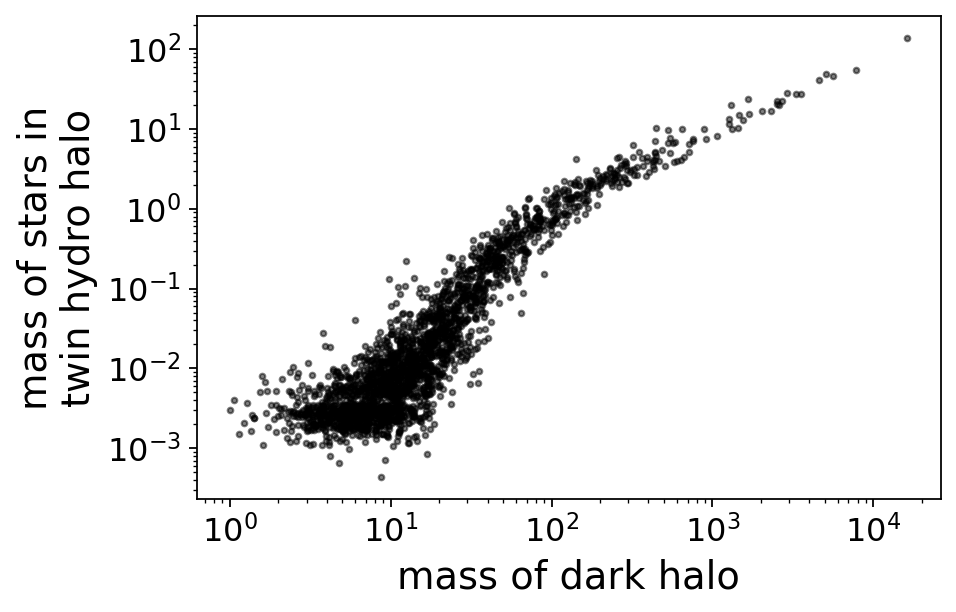

In [14]:
plt.scatter(masses_dark, y_scalar, color='k', alpha=0.5, s=6)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('mass of dark halo')
plt.ylabel('mass of stars in\ntwin hydro halo')

(29.512762, 803.55133)

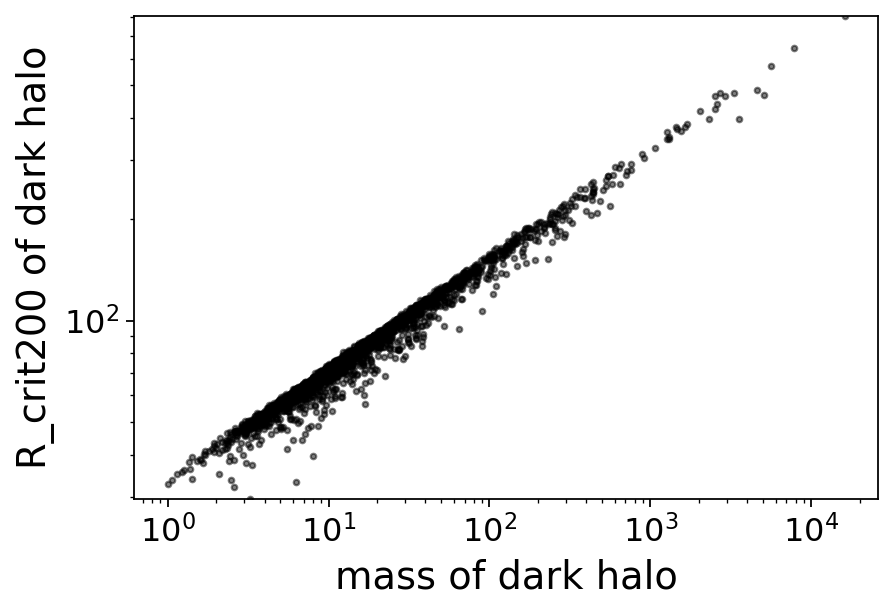

In [15]:
plt.scatter(masses_dark, r_crits, color='k', alpha=0.5, s=6)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('mass of dark halo')
plt.ylabel('R_crit200 of dark halo')

plt.ylim([min(r_crits[np.nonzero(r_crits)[0]]), max(r_crits)])

## Compute features

In [16]:
N_halos_subset = N_halos
print(N_halos, N_halos_subset)

np.random.seed(17)
idx_subset = np.random.choice(idx_halos_in_halodict, size=N_halos_subset, replace=False)
halo_dicts_subset = halo_dicts[idx_subset]
y_scalar_subset = y_scalar[idx_subset]

2342 2342


Set up parameters of features:

In [39]:
r_edges = np.array([0,1000]) #in ckpc/h. Typical halo sizes 50-200 ckpc/h. boxsize 51.7 Mpc
n_rbins = len(r_edges) - 1
print(r_edges)

l_arr = np.array([0, 1, 2, 3])
n_arr = np.arange(n_rbins)

[   0 1000]


Compute geometric features:

In [40]:
g_arrs_halos = []
g_normed_arrs_halos = []

for i_hd, halo_dict in enumerate(halo_dicts_subset):
    idx_halo_dark = halo_dict['idx_halo_dark']
    halo_dark_dm = il.snapshot.loadHalo(base_path_dark,snap_num,idx_halo_dark,'dm')
    x_halo_dark_dm = halo_dark_dm['Coordinates']
    x_halo_dark_dm_com = np.mean(x_halo_dark_dm, axis=0)
    
    # Subtract off center of mass for each halo
    x_data_halo = x_halo_dark_dm - x_halo_dark_dm_com
    #print(min(x_data_halo[:,0]), max(x_data_halo[:,0]))
    g_arrs, g_normed_arrs = scalars.get_geometric_features(x_data_halo, r_edges, l_arr, n_arr, m_dmpart)
    g_arrs_halos.append(g_arrs)
    g_normed_arrs_halos.append(g_normed_arrs)

In [41]:
print([g.shape for g in g_arrs_halos[0]])
print([g.shape for g in g_normed_arrs_halos[0]])

[(1,), (1, 3), (1, 3, 3), (1, 3, 3, 3)]
[(1,), (1, 3), (1, 3, 3), (1, 3, 3, 3)]


In [42]:
x_order_max = 0
m_order_max = 3
feature_names_to_include_also = []
#feature_names_to_include_also = ['s4']
x_scalar_dicts = np.empty(N_halos_subset, dtype=object)
x_scalar_features = []
for i_hd in range(N_halos_subset):
    scalar_dict_i = scalars.featurize_scalars(g_arrs_halos[i_hd], n_arr)
    scalars_i = []
    for key_name, scalar_ns in scalar_dict_i.items():
        for key_ns, scalar in scalar_ns.items():
            if (scalar['x_order'] <= x_order_max and scalar['m_order'] <= m_order_max 
                    or key_name in feature_names_to_include_also):
                scalars_i.append(scalar['value'])
    x_scalar_dicts[i_hd] = scalar_dict_i
    x_scalar_features.append(scalars_i)
x_scalar_features = np.array(x_scalar_features)
print(x_scalar_features.shape)

(2342, 4)


In [43]:
x_feature_scales = np.std(x_scalar_features, axis=0)
x_feature_scales[0] = 1.0
print(x_feature_scales)
print(x_feature_scales.shape)

[1.00000000e+00 3.46812099e+02 3.04866761e+06 3.40931002e+10]
(4,)


In [44]:
u,s,v = np.linalg.svd(x_scalar_features/x_feature_scales, full_matrices=False)

In [45]:
print(s)

[80.80342231 48.50209301 23.19617508  3.09062038]


## Plot features

In [46]:
show_intermediate_plots = True

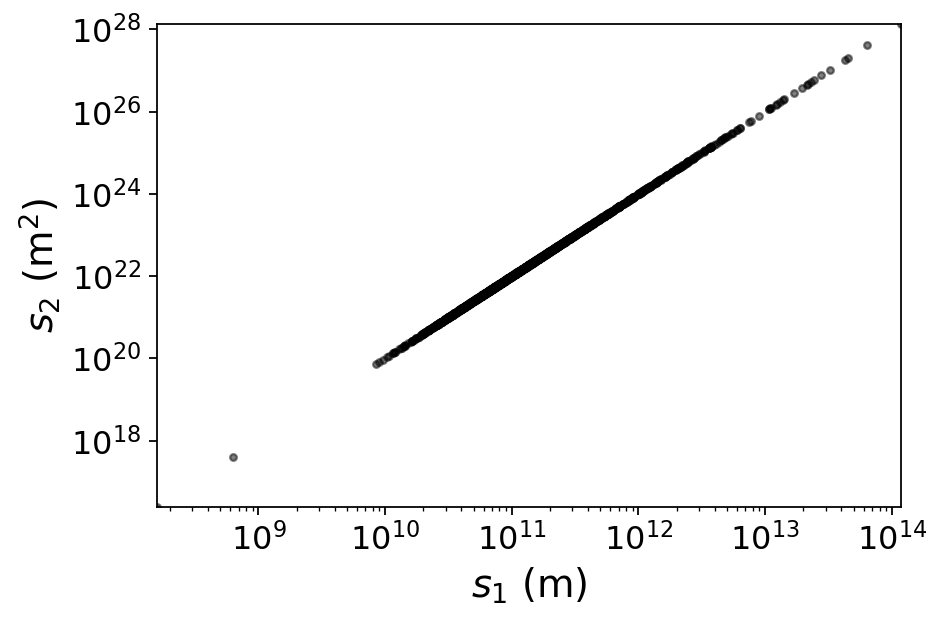

In [47]:
if show_intermediate_plots:
    plt.figure(figsize=(6,4))

    m_features = x_scalar_features[:,1]
    m2_features = x_scalar_features[:,2]
    plt.scatter(m_features*mass_multiplier, m2_features*mass_multiplier**2, ls='-', marker='.', 
                c='k', alpha=0.5)
    
    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel(r'$s_1$ (m)')
    plt.ylabel(r'$s_2$ (m$^2$)')
    
    plt.xlim([min(m_features[np.nonzero(m_features)])*mass_multiplier, 
              max(m_features)*mass_multiplier])
    plt.ylim([min(m2_features[np.nonzero(m2_features)])*mass_multiplier**2, 
              max(m2_features)*mass_multiplier**2])

In [48]:
print(len(m_features), np.count_nonzero(m_features))
print(len(m2_features), np.count_nonzero(m2_features))

2342 2299
2342 2299


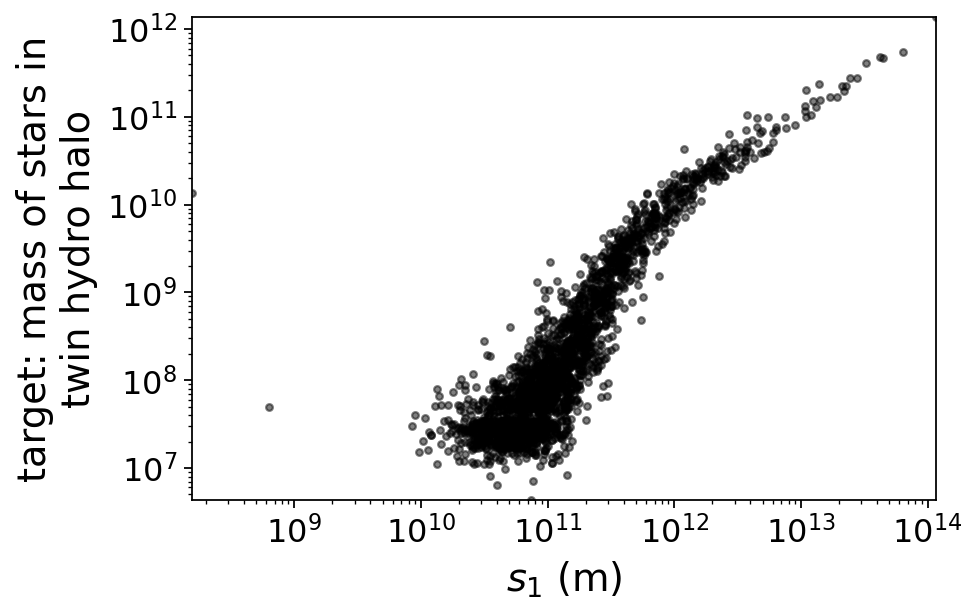

In [49]:
if show_intermediate_plots:
    plt.figure(figsize=(6,4))

    m_features = x_scalar_features[:,1]
    plt.scatter(m_features*mass_multiplier, y_scalar_subset*mass_multiplier, ls='-', marker='.', 
                c='k', alpha=0.5)
    
    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel(r'$s_1$ (m)')
    plt.ylabel('target: mass of stars in\ntwin hydro halo')
    
    plt.xlim([min(m_features[np.nonzero(m_features)])*mass_multiplier, 
              max(m_features)*mass_multiplier])
    plt.ylim([min(y_scalar_subset[np.nonzero(y_scalar_subset)])*mass_multiplier, 
              max(y_scalar_subset)*mass_multiplier])

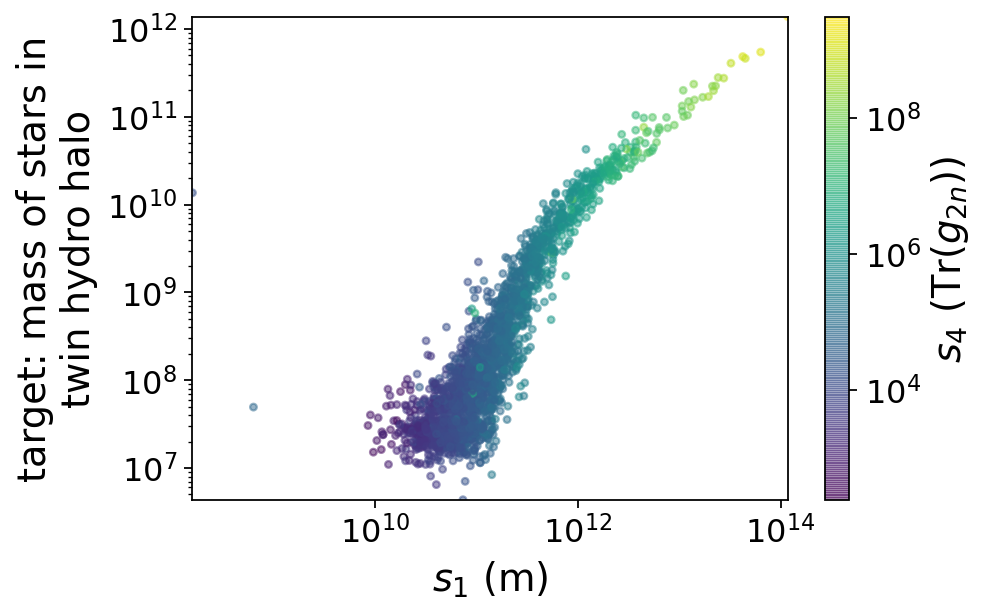

In [50]:
if show_intermediate_plots:
    plt.figure(figsize=(6,4))

    s1_features = []
    s4_features = []
    for scalar_dict_i in x_scalar_dicts:
        for key_ns in scalar_dict_i['s1']:
            s1_features.append(scalar_dict_i['s1'][key_ns]['value'])
            s4_features.append(scalar_dict_i['s4'][key_ns]['value'])
    s1_features = np.array(s1_features)
    s4_features = np.array(s4_features)

    plt.scatter(s1_features*mass_multiplier, y_scalar_subset*mass_multiplier, ls='-', marker='.', 
                c=s4_features, alpha=0.5, norm=matplotlib.colors.LogNorm())
    
    plt.colorbar(label=r'$s_4$ (Tr($g_{2n}$))')
    
    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel(r'$s_1$ (m)')
    plt.ylabel('target: mass of stars in\ntwin hydro halo')
    
    plt.xlim([min(s1_features[np.nonzero(s1_features)])*mass_multiplier, 
              max(s1_features)*mass_multiplier])
    plt.ylim([min(y_scalar_subset[np.nonzero(y_scalar_subset)])*mass_multiplier, 
              max(y_scalar_subset)*mass_multiplier])

## Perform linear regression

Split into train and test sets:

In [51]:
frac_test = 0.2
# split indices and then obtain training and test x and y, so can go back and get the full info later
np.random.seed(42)
idx_traintest = np.arange(N_halos_subset)
idx_test = np.random.choice(idx_traintest, size=int(frac_test*N_halos_subset), replace=False)
idx_train = np.setdiff1d(idx_traintest, idx_test, assume_unique=True)

#old way using scipy builtin:
#x_scalar_train, x_scalar_test, y_scalar_train, y_scalar_test = train_test_split(x_scalar_features, y_scalar_subset, test_size=frac_test, random_state=42)

x_scalar_train = x_scalar_features[idx_train]
x_scalar_test = x_scalar_features[idx_test]
y_scalar_train = y_scalar_subset[idx_train]
y_scalar_test = y_scalar_subset[idx_test]

x_scalar_dicts_train = x_scalar_dicts[idx_train]
x_scalar_dicts_test = x_scalar_dicts[idx_test]

n_train = len(x_scalar_train)
n_test = len(x_scalar_test)
print(n_train, n_test)

1874 468


Do least squares fit:

In [52]:
# solves b = ax (or, y = A theta); inputs are a, b (or, A, y)
# A, design matrix, is x here (features)

# scale features by their RMS
x_scales = np.sqrt(np.mean(x_scalar_train**2, axis=0))

res_scalar = np.linalg.lstsq(x_scalar_train/x_scales, y_scalar_train, rcond=None)
theta_scalar = res_scalar[0]/x_scales

In [53]:
# theta times the range tells us importance of features
print(theta_scalar)
print(np.mean(x_scalar_features, axis=0))
print(np.std(x_scalar_features, axis=0))
print(theta_scalar * np.std(x_scalar_features, axis=0))

[-7.86705690e-02  1.26609835e-02 -9.65799517e-07  7.56425100e-11]
[1.00000000e+00 5.34771323e+01 1.23138436e+05 9.33337724e+08]
[0.00000000e+00 3.46812099e+02 3.04866761e+06 3.40931002e+10]
[-0.          4.39098227 -2.94440171  2.57888767]


In [54]:
rank = res_scalar[2] 
print("rank:", rank)
print("n_feat:", x_scalar_features.shape[1])
assert theta_scalar.shape[0] == x_scalar_features.shape[1], 'Number of coefficients from theta vector should equal number of features!'

rank: 4
n_feat: 4


Predict on test data:

In [55]:
y_scalar_pred = x_scalar_test @ theta_scalar

In [56]:
print(min(y_scalar_test[np.nonzero(y_scalar_test)]), max(y_scalar_test))
print(min(y_scalar_pred[np.nonzero(y_scalar_pred)]), max(y_scalar_pred))

0.001098828506655991 22.359132766723633
-0.07867056898935224 23.216633381635464


Plot predictions:

<ipython-input-74-0921ffd12ff4>:34: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(m_minmin-0.2*m_spread, m_maxmax+0.2*m_spread)
<ipython-input-74-0921ffd12ff4>:35: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(m_minmin-0.2*m_spread, m_maxmax+0.2*m_spread)


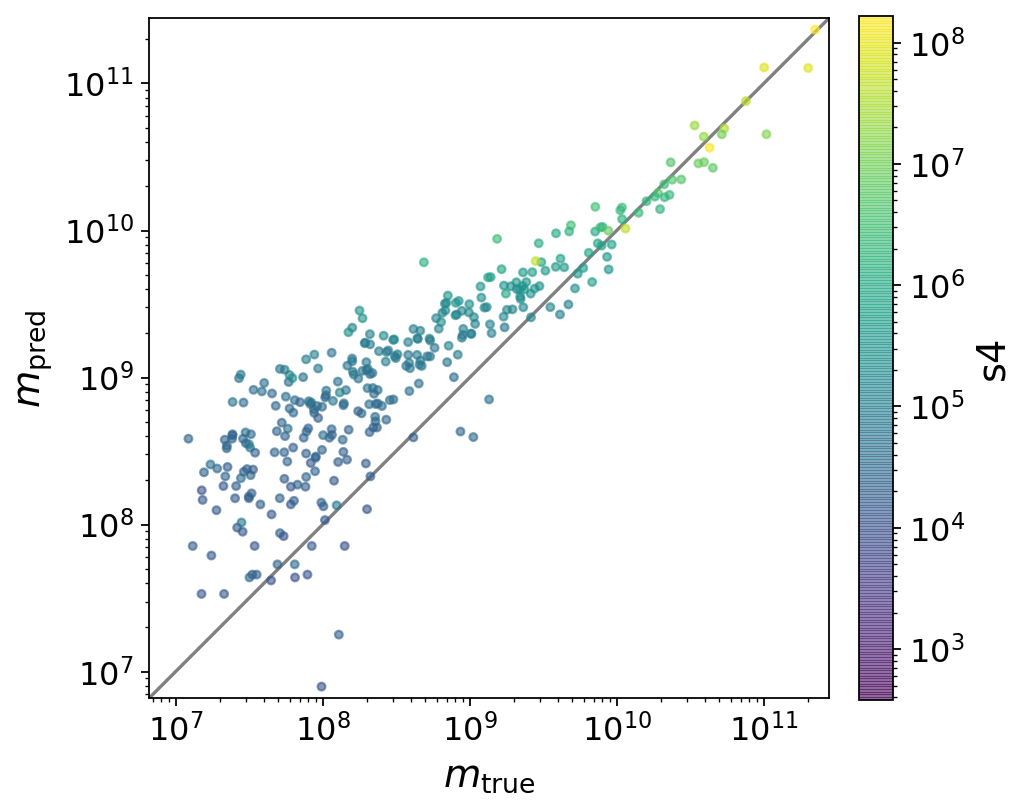

In [74]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

# get features to color plot by
feature_name_to_color_by = 's4'
features_color_by = np.empty(n_test)
for i_t in range(n_test):
    scalar_dict_i = x_scalar_dicts_test[i_t]
    for key_ns in scalar_dict_i[feature_name_to_color_by]:
        features_color_by[i_t] = scalar_dict_i[feature_name_to_color_by][key_ns]['value']
        
# main scatter plotting
plt.scatter(y_scalar_test*mass_multiplier, y_scalar_pred*mass_multiplier, s=12, alpha=0.6, 
            c=features_color_by, norm=matplotlib.colors.LogNorm())
#plt.scatter(y_scalar_test*mass_multiplier, y_scalar_pred*mass_multiplier, c='k', s=6, alpha=0.6)  

plt.colorbar(label=feature_name_to_color_by, fraction=0.046, pad=0.04)

# get limits, plot true line
m_minmin = min(min(y_scalar_test[np.nonzero(y_scalar_test)]), 
               min(y_scalar_pred[np.where(y_scalar_pred > 1)]))*mass_multiplier
m_maxmax = max(max(y_scalar_test[np.nonzero(y_scalar_test)]), 
               max(y_scalar_pred[np.nonzero(y_scalar_pred)]))*mass_multiplier
m_spread = m_maxmax - m_minmin
true_line = np.linspace(m_minmin-0.2*m_spread, m_maxmax+0.2*m_spread)
plt.plot(true_line, true_line, color='grey', zorder=0)

# labels & adjustments
plt.xlabel(r'$m_\mathrm{true}$')
plt.ylabel(r'$m_\mathrm{pred}$')
plt.xscale('log')
plt.yscale('log')
ax.set_aspect('equal')
plt.xlim(m_minmin-0.2*m_spread, m_maxmax+0.2*m_spread)
plt.ylim(m_minmin-0.2*m_spread, m_maxmax+0.2*m_spread)

# save
save_fn = f'mass_recovery{save_tag}.pdf'
if save_plots:
      plt.savefig(f"{plot_dir}/{save_fn}", bbox_inches='tight')

0.0 166722390.92946112


(-10.0, 10.0)

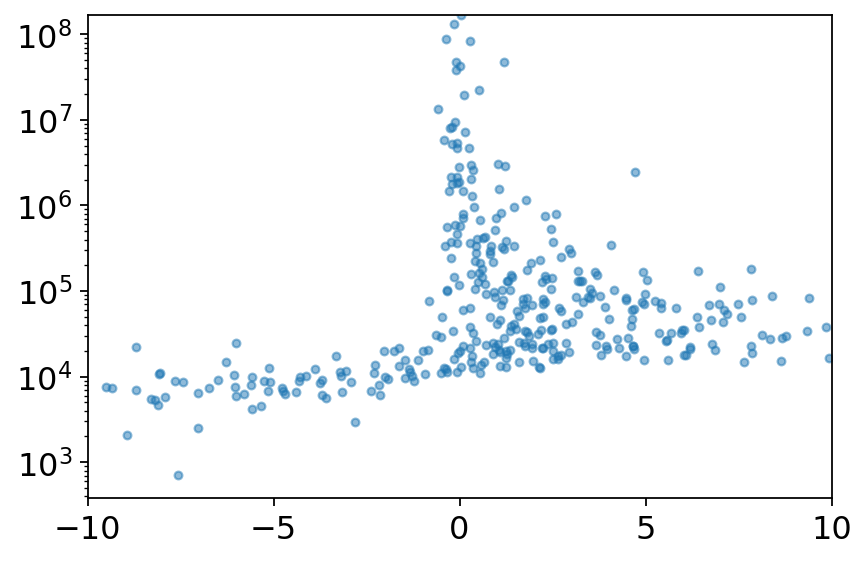

In [77]:
# don't need to include mass_multiplier in residual bc cancels out
residual = (y_scalar_pred - y_scalar_test)/y_scalar_test

plt.scatter(residual, features_color_by, s=12, alpha=0.5)
plt.yscale('log')

print(min(features_color_by), max(features_color_by))
plt.ylim([min(features_color_by[np.nonzero(features_color_by)[0]]), max(features_color_by)])
plt.xlim(-10,10)

(468, 9)


Text(0, 0.5, 'feature value')

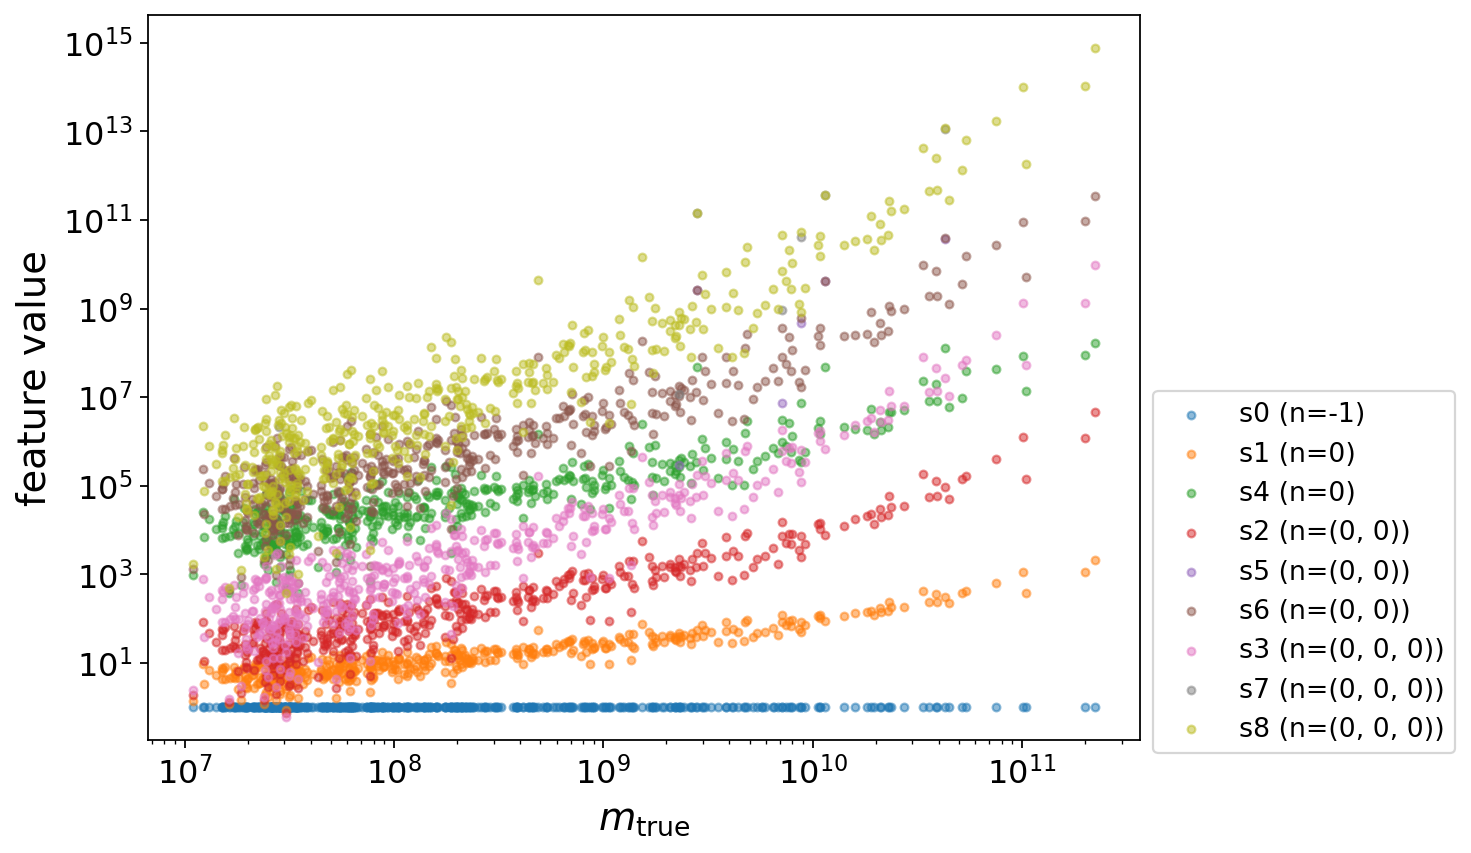

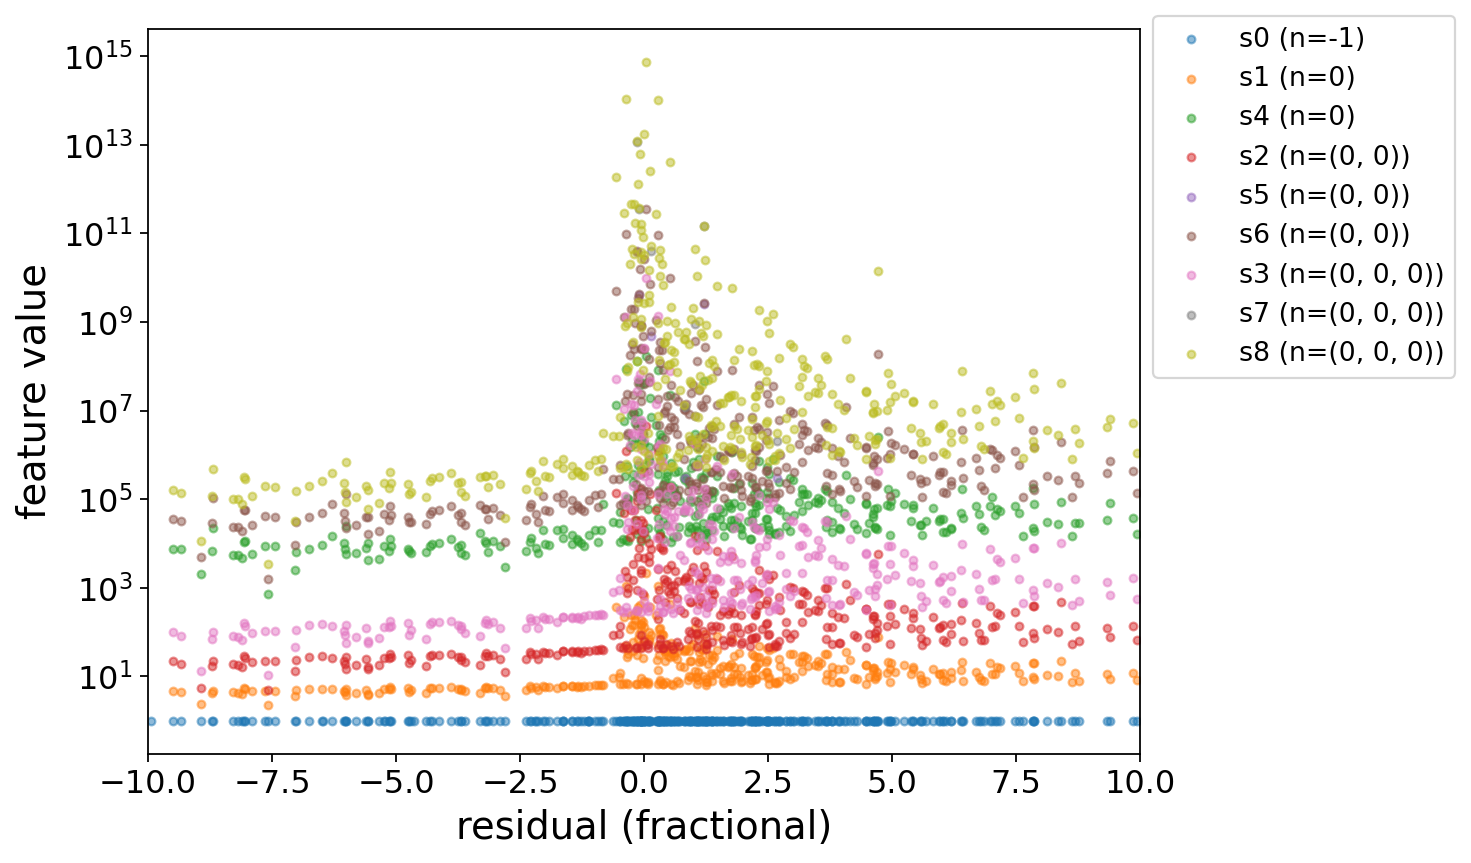

In [89]:

x_scalar_features_test_all = []
x_scalar_features_test_labels = []
for i_t in range(n_test):
    scalar_dict_i = x_scalar_dicts_test[i_t]
    scalars_i = []
    for key_name, scalar_ns in scalar_dict_i.items():
        for key_ns, scalar in scalar_ns.items():
            scalars_i.append(scalar['value'])
            if i_t==0:
                x_scalar_features_test_labels.append(f'{key_name} (n={key_ns})')
    x_scalar_features_test_all.append(scalars_i)
x_scalar_features_test_all = np.array(x_scalar_features_test_all)
print(x_scalar_features_test_all.shape)

# don't need to include mass_multiplier in residual bc cancels out
residual = (y_scalar_pred - y_scalar_test)/y_scalar_test

# MASS
plt.figure(figsize=(8,6))
for i in range(x_scalar_features_test_all.shape[1]):
    plt.scatter(y_scalar_test*mass_multiplier, x_scalar_features_test_all[:,i], s=12, alpha=0.5, label=x_scalar_features_test_labels[i])

plt.legend(fontsize=12, bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
#plt.ylim([min(features_color_by[np.nonzero(features_color_by)[0]]), max(features_color_by)])
#plt.xlim(-10,10)

plt.xlabel(r'$m_\mathrm{true}$')
plt.ylabel('feature value')

# RESID
plt.figure(figsize=(8,6))
for i in range(x_scalar_features_test_all.shape[1]):
    plt.scatter(residual, x_scalar_features_test_all[:,i], s=12, alpha=0.5, label=x_scalar_features_test_labels[i])

plt.legend(fontsize=12, bbox_to_anchor=(1, 0.5))
plt.yscale('log')
#plt.ylim([min(features_color_by[np.nonzero(features_color_by)[0]]), max(features_color_by)])
plt.xlim(-10,10)

plt.xlabel('residual (fractional)')
plt.ylabel('feature value')

In [59]:
print("In training set:")
print(f"Total number of halos: {len(y_scalar_train)}")
print(f"Number of zero-stellar-mass halos: {len(y_scalar_train) - np.count_nonzero(y_scalar_train)}")
print(f"Minimum nonzero mass: {min(y_scalar_train[np.nonzero(y_scalar_train)[0]])*mass_multiplier:.3e}")

In training set:
Total number of halos: 1874
Number of zero-stellar-mass halos: 0
Minimum nonzero mass: 4.349e+06


In [60]:
print("In test set:")
print(f"Total number of halos: {len(y_scalar_test)}")
print(f"Number of zero-stellar-mass halos: {len(y_scalar_test) - np.count_nonzero(y_scalar_test)}")
print(f"Minimum nonzero mass: {min(y_scalar_test[np.nonzero(y_scalar_test)[0]])*mass_multiplier:.3e}")
print()
print(f"Minimum nonzero predicted mass: {min(y_scalar_pred[np.nonzero(y_scalar_pred)[0]])*mass_multiplier:.3e}")
print(f"Minimum positive predicted mass: {min(y_scalar_pred[np.where(y_scalar_pred > 0)[0]])*mass_multiplier:.3e}")
print(f"Number mass predictions less than 1e5:", len(np.where(abs(y_scalar_pred*mass_multiplier) < 1e5)[0]))

In test set:
Total number of halos: 468
Number of zero-stellar-mass halos: 0
Minimum nonzero mass: 1.099e+07

Minimum nonzero predicted mass: -7.867e+08
Minimum positive predicted mass: 1.945e+06
Number mass predictions less than 1e5: 0
